# ASR-MT
## Lucida AI Evaluation

### Goal
Investigate the relationship between the errors of ASR (Automatic Speech Recognition) and the errors of MT (Machine Translation).

### Infrastructure Architecture
![alt text](diagram.png "Infrastructure Architecture")

### Generate Quries from Original Data

100 sentences.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re, string, sys
from operator import itemgetter
import matplotlib.pyplot as plt
fig = plt.figure()
plt.rc("font", family="serif")
plt.rc("font", size=15)

In [2]:
# Return the Ensligh text corresponding to the specific sentence.
def get_English_text(id):
    links_with_id = links.loc[links['id'] == id]
    for translation_id in links_with_id['translation_id']:
        data_with_id = data.loc[data['id'] == translation_id]
        for index, row in data_with_id.iterrows():
            if row['lang'] == 'eng':
                return row['text']

# Generate 100 queires from the original data files
# 'sentences.csv' and 'links.csv'.
# Format: 'Ensligh text','Chinese text'
# Save the queries to 'text/query.txt'.
# Data source: http://tatoeba.org/eng/downloads.
def generate_100_queires():
    data = pd.read_csv('sentences.csv', \
                       names = ["id", "lang", "text"], delimiter='\t')
    chinese_rows = data.loc[data['lang'] == 'cmn']
    links = pd.read_csv('links.csv', \
                        names = ["id", "translation_id"], delimiter='\t')
    num_queries = 100
    header = ['query', 'answer']
    query_data = pd.DataFrame(np.zeros((num_queries, len(header))), \
                              columns=header)
    # Randomly select 1000 rows, and pick 100 from them as queries.
    chinese_rows = chinese_rows.ix[np.random.choice(chinese_rows.index, 1000)]
    chinese_rows = chinese_rows.assign(english=np.zeros(chinese_rows.shape[0]))
    count = 0
    for index, row in chinese_rows.iterrows():
        if count >= num_queries:
            break
        english = get_English_text(row['id'])
        # Prefer long sentences without '.', ';', '?', or '!'.
        if english is not None and not '.' in english[0:-1] and \
        not ';' in english[0:-1] and not '?' in english[0:-1] and \
        not '!' in english[0:-1] and \
        len(english.split()) >= 10:
            query_data.ix[count, 'query'] = english
            query_data.ix[count, 'answer'] = row['text']
            count += 1
    if count < num_queries:
        raise RuntimeError('Too few data!')
    query_data.to_csv('text/query.txt')
    
# generate_100_queires()

In [3]:
# Generate the transcript with all the 100 English sentences in it
# stored in 'speech/transcript.txt'.
def generate_transcript():
    query_data = pd.read_csv('text/query.txt')
    file = open('speech/transcript.txt', 'w')
    for english in query_data['english']:
        file.write(english + '\n')
    print('Use the transcript to generate audio files!')
        
# generate_transcript()

### Convert Traditional Chinese to Simplified Chinese

[This tool](https://www.branah.com/traditional-to-simplified) could help.

### Generate Raw Data by Sending Queries to the Pipeline

### Generate DataFrame from ASR Results

In [4]:
# Return a DataFrame from the file with the following format:
# <audio_path>,<transcript>
# in which the audio path is of the following format:
# "path/to/file/<query_id>_<text>.wav"
# An example file:
# ../asr_mt/speech/0_Helloworld.wav,"hello world."
# Its first line must have be the header!
# The DataFrame has only one column: transcript
# with the specified header
# and sorted by the query id.
def get_df_from_asr_result(file_path, header):
    file = open(file_path, 'r')
    lines = file.readlines()
    lines.pop(0) # pop the header
    file.close()
    proc_lines = []
    for line in lines:
        line = line.lstrip().rstrip('\n')
        # The first occurrence of a number is assumed to be the query id.
        id = int(re.search(r'\d+', line).group())
        transcript = line.split(',')[1]
        if transcript.startswith('"') and transcript.endswith('"'):
            transcript = transcript[1:-1]
        proc_lines.append((id, transcript))
    proc_lines.sort(key=itemgetter(0)) # sort data by ID
    df = pd.DataFrame([row[1] for row in proc_lines], columns=[header])
    return df

# data = pd.read_csv('text/query.txt', index_col=0)

# asr_labels = ['fisher', 'librispeech', 'tedlium']

# for asr_label in asr_labels:
#     data = data.join \
#     (get_df_from_asr_result('asr_result_{}.txt'.format(asr_label), \
#                             'transcript_{}'.format(asr_label)))

In [5]:
oldstdout = sys.stdout
# sys.stdout = open('log.txt', 'w')
# Return a DataFrame from Google MT result data
# and evaluate the result using the BLEU metric.
# In order to match the query in the Google MT result data
# to the query in `data`,
# the column name to match should be specified.
def get_df_from_google_result(mt_label, data, match_col):
    sys.path.append('../../mt')
    from bleu import Evaluator
    e = Evaluator()
    google_data = pd.read_csv('mt_result_{}.txt'.format(mt_label))
    results = []
    for j, asr_output in enumerate(data[match_col]):
        print(mt_label, asr_output)
        print(data['query'].ix[j])
        match_row = -1
        if asr_output != '':
            for i, mt_input in enumerate(google_data['text']):
                # Some weird problem leads to some '"' left in the sentence.
                mt_input = mt_input.replace('"', '')
                if mt_input == asr_output.replace('"', ''):
                    match_row = i
                    break
            if match_row == -1:
                raise RuntimeError('Cannot find the query ' + asr_output)
            result = google_data['translation'].ix[match_row]
        else:
            result = None # ASR did not return any result, so MT must be wrong!
        score = e.evaluate(result, data['answer'].ix[j])
        results.append((j, result, score))
        sys.stdout.flush()
    assert(len(results) == data.shape[0])
    results.sort(key=itemgetter(0)) # sort data by row index
    df = pd.DataFrame({'answer_{}'.format(mt_label): [row[1] for row in results], \
                      'score_{}'.format(mt_label): [row[2] for row in results]})
    return df
    
# mt_labels = [('fisher_google', 'transcript_fisher'), \
#              ('fisher_microsoft', 'transcript_fisher'), \
#              ('librispeech_google', 'transcript_librispeech'), \
#              ('librispeech_microsoft', 'transcript_librispeech'), \
#              ('tedlium_google', 'transcript_tedlium'), \
#              ('tedlium_microsoft', 'transcript_tedlium'), \
#              ('regular_google', 'query'), \
#              ('regular_microsoft', 'query')]

# for mt_label, match_col in mt_labels:
#     data = data.join \
#     (get_df_from_google_result(mt_label, data, match_col), lsuffix='')
# data = data[['query', 'answer', 
#              'answer_regular_google', 'score_regular_google', \
#              'answer_regular_microsoft', 'score_regular_microsoft', \
#              'transcript_fisher', \
#              'answer_fisher_google', 'score_fisher_google', \
#              'answer_fisher_microsoft', 'score_fisher_microsoft', \
#              'transcript_librispeech', \
#              'answer_librispeech_google', 'score_librispeech_google', \
#              'answer_librispeech_microsoft', 'score_librispeech_microsoft', \
#              'transcript_tedlium', \
#              'answer_tedlium_google', 'score_tedlium_google', \
#              'answer_tedlium_microsoft', 'score_tedlium_microsoft']]
# data.to_csv('data.txt') # save to disk
sys.stdout = oldstdout

### Observation

### BLEU Metric for Machine Translation

In [6]:
sys.path.append('../../mt')
from bleu import Evaluator
e = Evaluator()
score = e.evaluate('人生是短暂的我们不应该浪费时间。', '人生十分短暂，我们不应该浪费时间。')

Result: ['人生', '是', '短暂', '的', '我们', '不', '应该', '浪费时间', '。']
Correct: ['人生', '十分', '短暂', '，', '我们', '不', '应该', '浪费时间', '。']
Score: 0.4854917717073234


In [7]:
score = e.evaluate('人生十分短暂，我们不应该浪费时间。', '人生十分短暂，我们不应该浪费时间。')

Result: ['人生', '十分', '短暂', '，', '我们', '不', '应该', '浪费时间', '。']
Correct: ['人生', '十分', '短暂', '，', '我们', '不', '应该', '浪费时间', '。']
Score: 1.0


### Performance of BLEU

- High correlation with human judgement

- Benchmark for evalutation of new metrics

- Inherent Problem: Cannot consider all reference translations (only one in this case)

In [8]:
from IPython.display import display
pd.set_option('display.max_colwidth', -1) # display full text
data = pd.read_csv('data.txt', index_col=0)
pd.set_option('display.max_columns', data.shape[1]) # display all columns
data[0:1]

,query,answer,answer_regular_google,score_regular_google,answer_regular_microsoft,score_regular_microsoft,transcript_fisher,answer_fisher_google,score_fisher_google,answer_fisher_microsoft,score_fisher_microsoft,transcript_librispeech,answer_librispeech_google,score_librispeech_google,answer_librispeech_microsoft,score_librispeech_microsoft,transcript_tedlium,answer_tedlium_google,score_tedlium_google,answer_tedlium_microsoft,score_tedlium_microsoft
0,"Life being very short, we ought not to waste time.",人生十分短暂，我们不应该浪费时间。,人生十分短促，我们不应该浪费时间。,0.660633,生命是短暂的我们不应该浪费时间。,0.467138,i've been very shortly out not to waste time.,我已经很短了不是浪费时间。,0.451801,我一直非常短，不想浪费时间。,0.485492,I'VE BEEN VERY SHORTLY OUGHT NOT TO WASTE TIME.,我已经很短不应该浪费时间。,0.305098,我一直非常短不应该浪费时间。,0.305098,i've been very short we are not to waste time.,我已经很短，我们不能浪费时间。,0.379918,我已经很短了，我们是不想浪费时间。,0.5491


### Collect Statistics and Plot

### Plot Google MT Performance

1. Baseline is Google MT with the original text query

2. Score is relative to the baseline:

    - If the baseline is more correct, the score is -1

    - If the baseline is more wrong, the score is +1

    - Otherwise, the score is 0


In [9]:
sys.path.append('../../asr')
from wer import error_rate

# Analyze the data for the specified ASR and return the statistics.
def analyze(data, asr_name, mt_name):
    size = data.shape[0]
    asr_errors = np.zeros(size)
    for j, transcript in enumerate(data['_'.join(['transcript', asr_name])]):
        asr_errors[j] = error_rate(data['query'][j], transcript)
    relative_scores = np.zeros(size)
    with_asr_scores = data['_'.join(['score', asr_name, mt_name])]
    regular_scores = data['_'.join(['score', 'regular', mt_name])]
    for j, answer in enumerate(data['_'.join(['answer', asr_name, mt_name])]):
        with_asr_score = with_asr_scores[j]
        regular_score = regular_scores[j]
        if with_asr_score == regular_score:
            relative_scores[j] = 0
        elif with_asr_score > regular_score:
            relative_scores[j] = -1
        else:
            relative_scores[j] = 1
    avg_mt_accuracy = np.mean(with_asr_scores)
    avg_regular_mt_accuracy = np.mean(regular_scores)
    print('avg_asr_error:', asr_errors.mean(), \
          'avg_mt_accuracy:', avg_mt_accuracy, \
          'avg_regular_mt_accuracy', avg_regular_mt_accuracy)
    return {'asr_name': asr_name, 'mt_name': mt_name, \
            'asr_errors': asr_errors, \
            'avg_asr_error': asr_errors.mean(), \
            'relative_scores': relative_scores, \
            'avg_mt_accuracy': avg_mt_accuracy, \
            'avg_regular_mt_accuracy': avg_regular_mt_accuracy}

# Plot the relative scores vs error rates for a particular ASR+MT combination.
def plot_score_vs_error(color, asr_name, mt_name, asr_errors, relative_scores, **extras):
    plt.xlabel('ASR Error Rate')
    plt.ylabel('MT Relative Score')
    plt.title(' '.join([asr_name, mt_name]))
    plt.scatter(asr_errors, relative_scores, label=asr_name, color=color)

avg_asr_error: 0.564885933315 avg_mt_accuracy: 0.41885960247208964 avg_regular_mt_accuracy 0.4198994234372686


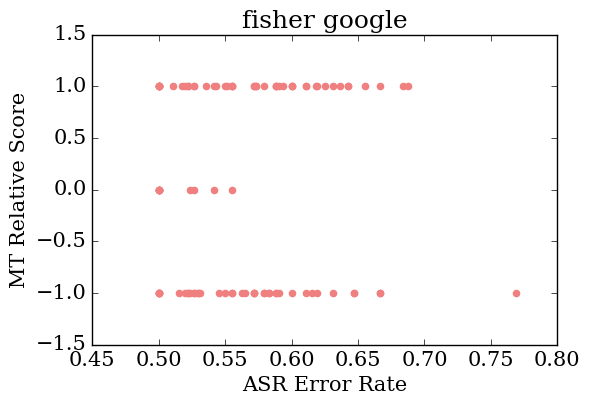

In [10]:
google_stats_list = []
google_stats_list.append(analyze(data, 'fisher', 'google'))
plot_score_vs_error('lightcoral', **google_stats_list[-1])

avg_asr_error: 0.530527658904 avg_mt_accuracy: 0.3800859916287618 avg_regular_mt_accuracy 0.4198994234372686


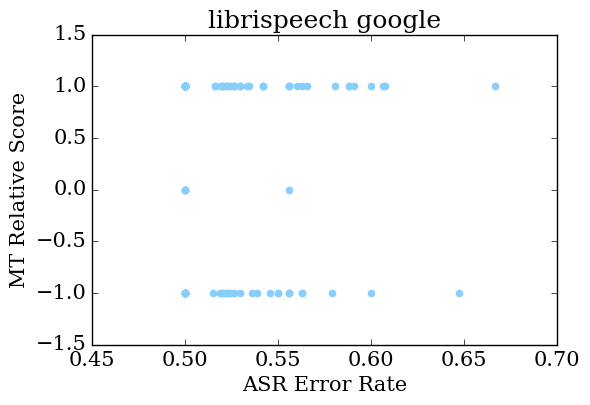

In [11]:
google_stats_list.append(analyze(data, 'librispeech', 'google'))
plot_score_vs_error('lightskyblue', **google_stats_list[-1])

avg_asr_error: 0.545100484111 avg_mt_accuracy: 0.38055289330061115 avg_regular_mt_accuracy 0.4198994234372686


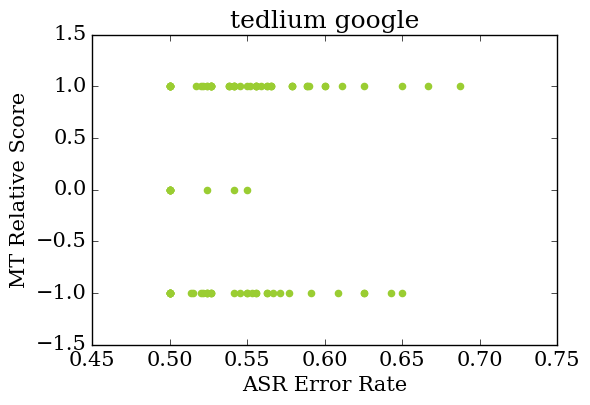

In [12]:
google_stats_list.append(analyze(data, 'tedlium', 'google'))
plot_score_vs_error('yellowgreen', **google_stats_list[-1])

In [22]:
# Return the data from the list of MT statistics (one for each ASR model).
def gather_data_for_mt_vs_asr(stats_list):
    asr_name_list = [stats['asr_name'] for stats in stats_list]
    avg_asr_accuracy_list = [1 - stats['avg_asr_error'] for stats in stats_list]
    avg_mt_accuracy_list = [stats['avg_mt_accuracy'] for stats in stats_list]
    avg_regular_mt_accuracy_list = \
    [stats['avg_regular_mt_accuracy'] for stats in stats_list]
    avg_mt_accuracy_drop_list = \
    [stats['avg_mt_accuracy'] - avg_regular_mt_accuracy_list[i] \
     for i, stats in enumerate(stats_list)]
    avg_mt_accuracy_drop_percentage_list = \
    [ (avg_mt_accuracy_drop / avg_regular_mt_accuracy_list[i]) * 100 \
     for i, avg_mt_accuracy_drop in enumerate(avg_mt_accuracy_drop_list)]
    return asr_name_list, avg_asr_accuracy_list, avg_mt_accuracy_list, \
avg_regular_mt_accuracy_list, avg_mt_accuracy_drop_list, \
avg_mt_accuracy_drop_percentage_list

# Plot the performance of a particular MT under the influence of different ASR models.
def plot_mt_vs_asr(stats_list, mt_name, color):  
    assert(len(stats_list) != 0)
    plt.xlabel('Average ASR Accuracy')
    plt.ylabel('Average MT Accuracy')
    plt.title('Performace of {}\n under the influence of ASR'.format(mt_name))
    # Gather data.
    asr_name_list, avg_asr_accuracy_list, avg_mt_accuracy_list, \
    avg_regular_mt_accuracy_list, \
    avg_mt_accuracy_drop_list, avg_mt_accuracy_drop_percentage_list = \
    gather_data_for_mt_vs_asr(stats_list)
    # Plot.
    plt.scatter(avg_asr_accuracy_list, avg_mt_accuracy_list, color=color)
    for i, avg_asr_accuracy in enumerate(avg_asr_accuracy_list):
        txt = '{} ({:.2f},{:.3f})\n$\Delta$Accuracy={:.3f}\n({:.2f}%)'.format \
        (asr_name_list[i], avg_asr_accuracy, avg_mt_accuracy_list[i], \
         avg_mt_accuracy_drop_list[i], \
         avg_mt_accuracy_drop_percentage_list[i])
        plt.annotate(txt, (avg_asr_accuracy, avg_mt_accuracy_list[i]), \
                    fontsize=10)

# Plot the performance of a different MTs under the influence of different ASR models.
def plot_mts_vs_asr(list_of_stats_list, list_of_mt_name, list_of_colors):
    assert(len(list_of_stats_list) != 0)
    assert(len(list_of_stats_list[0]) != 0)
    assert(len(list_of_stats_list) == len(list_of_mt_name))
    assert(len(list_of_mt_name) == len(list_of_colors))
    plt.xlabel('Average ASR Accuracy')
    plt.ylabel('Average MT Accuracy')
    plt.title('Performace of {}\nunder the influence of ASR'. \
              format(', '.join(list_of_mt_name)))
    for i, stats_list in enumerate(list_of_stats_list):
        mt_name = list_of_mt_name[i]
        # Gather data.
        asr_name_list, avg_asr_accuracy_list, avg_mt_accuracy_list, \
        avg_regular_mt_accuracy_list, \
        avg_mt_accuracy_drop_list, avg_mt_accuracy_drop_percentage_list = \
        gather_data_for_mt_vs_asr(stats_list)
        # Plot.
        plt.scatter(avg_asr_accuracy_list, avg_mt_accuracy_list, \
                    label='{} with ASR'.format(mt_name), \
                    color=list_of_colors[i])
        xs = np.arange(0.42, 0.50, 0.02)
        plt.plot(xs, \
                 np.full(xs.shape, avg_regular_mt_accuracy_list[0]), \
                 'k--', color=list_of_colors[i], \
                 label='{} Regular'.format(mt_name))
        plt.legend(loc='best', fontsize=9)
        for i, avg_asr_accuracy in enumerate(avg_asr_accuracy_list):
            txt = '{}'.format(asr_name_list[i])
            plt.annotate(txt, (avg_asr_accuracy, avg_mt_accuracy_list[i]), \
                         fontsize=10)

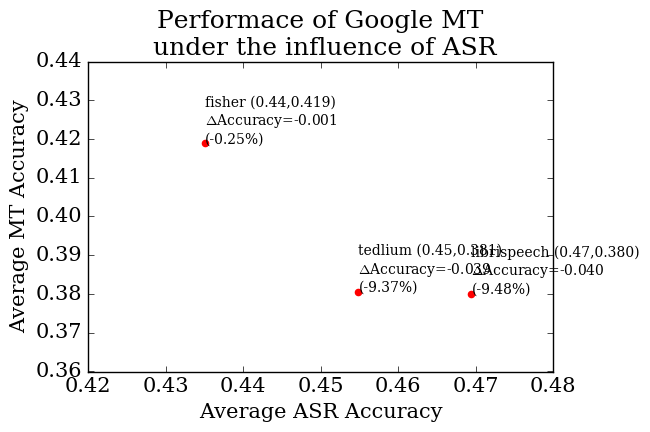

In [14]:
plot_mt_vs_asr(google_stats_list, 'Google MT', 'red')

### Plot Microsoft MT Performance

avg_asr_error: 0.564885933315 avg_mt_accuracy: 0.4300187689135786 avg_regular_mt_accuracy 0.4441484333503438


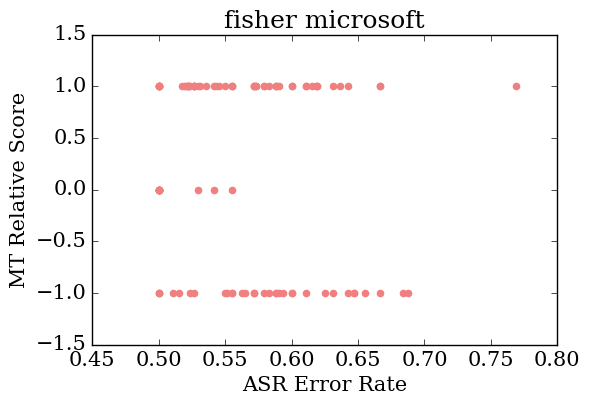

In [15]:
microsoft_stats_list = []
microsoft_stats_list.append(analyze(data, 'fisher', 'microsoft'))
plot_score_vs_error('lightcoral', **microsoft_stats_list[-1])

avg_asr_error: 0.530527658904 avg_mt_accuracy: 0.42249781261617936 avg_regular_mt_accuracy 0.4441484333503438


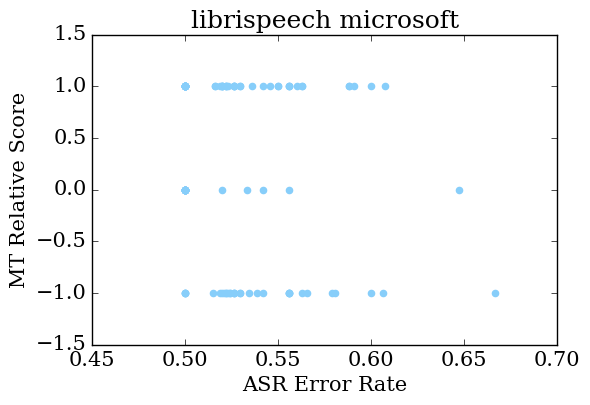

In [16]:
microsoft_stats_list.append(analyze(data, 'librispeech', 'microsoft'))
plot_score_vs_error('lightskyblue', **microsoft_stats_list[-1])

avg_asr_error: 0.545100484111 avg_mt_accuracy: 0.40799365547883587 avg_regular_mt_accuracy 0.4441484333503438


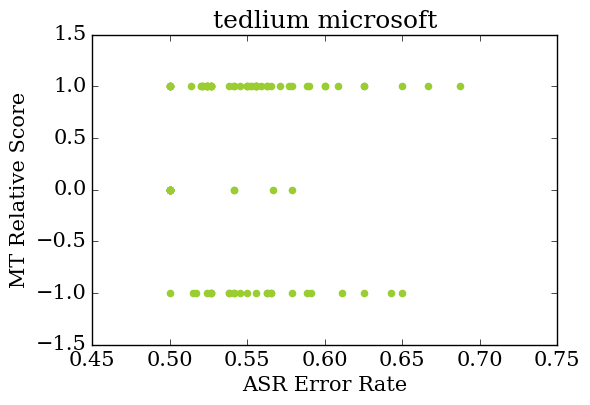

In [17]:
microsoft_stats_list.append(analyze(data, 'tedlium', 'microsoft'))
plot_score_vs_error('yellowgreen', **microsoft_stats_list[-1])

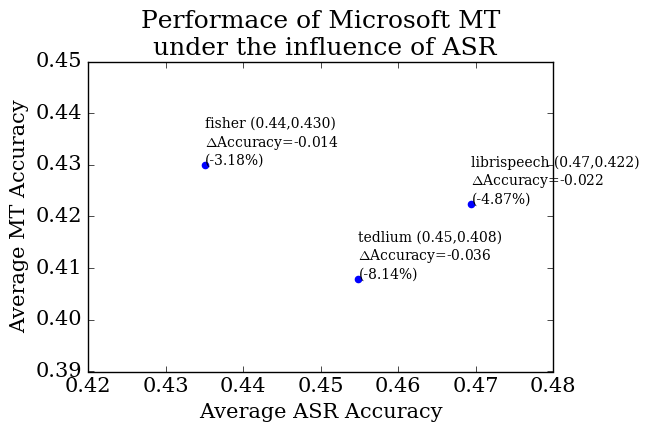

In [18]:
plot_mt_vs_asr(microsoft_stats_list, 'Microsoft MT', 'blue')

### Summary

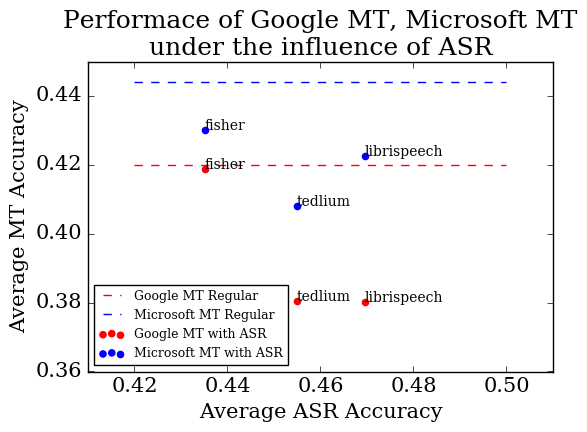

In [23]:
plot_mts_vs_asr([google_stats_list, microsoft_stats_list], \
                ['Google MT', 'Microsoft MT'], ['red', 'blue'])